In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2
import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [ ]:

train_img_paths = sorted(glob('/content/Data/Data/train/image/*.png'))
train_mask_paths = sorted(glob('/content/Data/Data/train/mask/*.png'))

train_df = pd.DataFrame({"images": train_img_paths, "masks": train_mask_paths})
train_df.head()


,images,masks
0,/content/Data/Data/train/image/0.png,/content/Data/Data/train/mask/0.png
1,/content/Data/Data/train/image/1.png,/content/Data/Data/train/mask/1.png
2,/content/Data/Data/train/image/10.png,/content/Data/Data/train/mask/10.png
3,/content/Data/Data/train/image/11.png,/content/Data/Data/train/mask/11.png
4,/content/Data/Data/train/image/12.png,/content/Data/Data/train/mask/12.png


In [ ]:

test_img_paths = sorted(glob('/content/Data/Data/test/image/*.png'))
test_mask_paths = sorted(glob('/content/Data/Data/test/mask/*.png'))
test_df = pd.DataFrame({"images":test_img_paths,"masks":test_mask_paths})
test_df.head()


,images,masks
0,/content/Data/Data/test/image/0.png,/content/Data/Data/test/mask/0.png
1,/content/Data/Data/test/image/1.png,/content/Data/Data/test/mask/1.png
2,/content/Data/Data/test/image/10.png,/content/Data/Data/test/mask/10.png
3,/content/Data/Data/test/image/11.png,/content/Data/Data/test/mask/11.png
4,/content/Data/Data/test/image/12.png,/content/Data/Data/test/mask/12.png


Purpose of this code:

1- Initialization: Sets up paths for images and masks and counts the total number of samples.

2- Data Retrieval: Loads and preprocesses images and masks for each index, converting them to PyTorch tensors.

3- Length Calculation: Returns the number of samples available in the dataset.

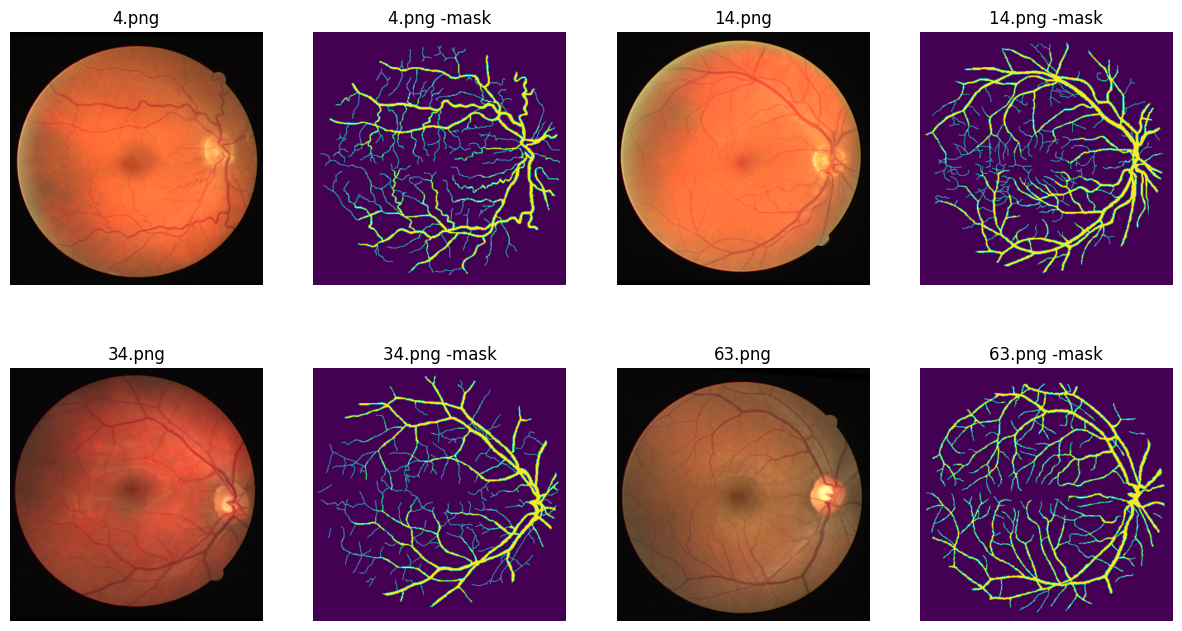

In [ ]:
show_imgs = 4
idx = np.random.choice(len(train_df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = train_df.loc[idx[new_i]]['images']
        basename = os.path.basename(full_path)
    else:
        full_path = train_df.loc[idx[new_i]]['masks']
        basename = os.path.basename(full_path) + ' -mask'
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()


In [ ]:
def dice_coefficient(pred, target, threshold=0.5):
    # Binarize predictions
    pred = (pred > threshold).float()
    # Flatten the tensors
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    # Compute intersection and union
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    # Compute Dice coefficient
    dice = 2. * intersection / union if union != 0 else torch.tensor(1.0)
    return dice.item()

In [ ]:
rain_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04, 0.04), rotate_limit=(-15, 15), p=0.5),
    A.ElasticTransform(alpha=1.0, sigma=50.0, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.RandomSizedCrop(min_max_height=(450, 512), height=512, width=512, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
])

test_transforms = A.Compose([
    A.Resize(512, 512),

])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(test_df, test_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(test_df)}')

len train: 80
len val: 20


Purpose of this code:

1- Applies a series of convolutional operations followed by batch normalization and ReLU activation.( two sets of operations)


2- Normalizes and activates the output of each convolution, helping in training deeper networks by addressing issues like internal covariate shift and introducing non-linearity.

In [ ]:
class_size = 1
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size,                      # model output channels (number of classes in your dataset)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model(torch.randn((1,3,512,512))).shape

torch.Size([1, 1, 512, 512])

In [ ]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        # print(f'train_acc: {acc}')
        epoch_iou_score += iou_score
        lr_scheduler.step()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_iou_score/num_batches



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            # print(f'val_acc: {acc}')
            epoch_iou_score += iou_score
            # size += y.shape[0]
    return epoch_loss/num_batches, epoch_iou_score/num_batches

In [ ]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.5)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)


    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    # On epoch end
    torch.save(model.state_dict(), "checkpoints/last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break


  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.2814, val_loss: 0.2665     train_iou_score: 0.582, val_iou_score: 0.605     lr: 0.0005


  2%|▏         | 1/50 [00:15<12:15, 15.00s/it]

EPOCH: 002     train_loss: 0.2606, val_loss: 0.2478     train_iou_score: 0.605, val_iou_score: 0.624     lr: 0.00025


  4%|▍         | 2/50 [00:25<09:41, 12.12s/it]

EPOCH: 003     train_loss: 0.2526, val_loss: 0.2322     train_iou_score: 0.612, val_iou_score: 0.645     lr: 0.000125


  6%|▌         | 3/50 [00:35<08:46, 11.20s/it]

EPOCH: 004     train_loss: 0.2467, val_loss: 0.2274     train_iou_score: 0.619, val_iou_score: 0.652     lr: 6.25e-05


  8%|▊         | 4/50 [00:45<08:19, 10.85s/it]

EPOCH: 005     train_loss: 0.2451, val_loss: 0.2332     train_iou_score: 0.621, val_iou_score: 0.644     lr: 3.125e-05


 10%|█         | 5/50 [00:55<07:46, 10.36s/it]

EPOCH: 006     train_loss: 0.2445, val_loss: 0.2289     train_iou_score: 0.622, val_iou_score: 0.649     lr: 1.5625e-05


 12%|█▏        | 6/50 [01:04<07:23, 10.09s/it]

EPOCH: 007     train_loss: 0.2423, val_loss: 0.2250     train_iou_score: 0.624, val_iou_score: 0.654     lr: 7.8125e-06


 14%|█▍        | 7/50 [01:14<07:10, 10.02s/it]

EPOCH: 008     train_loss: 0.2433, val_loss: 0.2241     train_iou_score: 0.623, val_iou_score: 0.655     lr: 3.90625e-06


 16%|█▌        | 8/50 [01:24<07:00, 10.01s/it]

EPOCH: 009     train_loss: 0.2443, val_loss: 0.2247     train_iou_score: 0.621, val_iou_score: 0.654     lr: 1.953125e-06


 18%|█▊        | 9/50 [01:34<06:49,  9.99s/it]

EPOCH: 010     train_loss: 0.2438, val_loss: 0.2240     train_iou_score: 0.622, val_iou_score: 0.655     lr: 9.765625e-07


 20%|██        | 10/50 [01:44<06:38,  9.97s/it]

EPOCH: 011     train_loss: 0.2431, val_loss: 0.2234     train_iou_score: 0.623, val_iou_score: 0.656     lr: 4.8828125e-07


 22%|██▏       | 11/50 [01:54<06:29,  9.99s/it]

EPOCH: 012     train_loss: 0.2426, val_loss: 0.2240     train_iou_score: 0.624, val_iou_score: 0.655     lr: 2.44140625e-07


 24%|██▍       | 12/50 [02:03<06:12,  9.81s/it]

EPOCH: 013     train_loss: 0.2429, val_loss: 0.2250     train_iou_score: 0.623, val_iou_score: 0.654     lr: 1.220703125e-07


 26%|██▌       | 13/50 [02:13<06:00,  9.74s/it]

EPOCH: 014     train_loss: 0.2416, val_loss: 0.2245     train_iou_score: 0.625, val_iou_score: 0.654     lr: 6.103515625e-08


 28%|██▊       | 14/50 [02:22<05:48,  9.69s/it]

EPOCH: 015     train_loss: 0.2445, val_loss: 0.2252     train_iou_score: 0.621, val_iou_score: 0.653     lr: 3.0517578125e-08


 30%|███       | 15/50 [02:32<05:38,  9.68s/it]

EPOCH: 016     train_loss: 0.2426, val_loss: 0.2249     train_iou_score: 0.624, val_iou_score: 0.654     lr: 1.52587890625e-08


 30%|███       | 15/50 [02:41<06:17, 10.80s/it]

Earlystop!


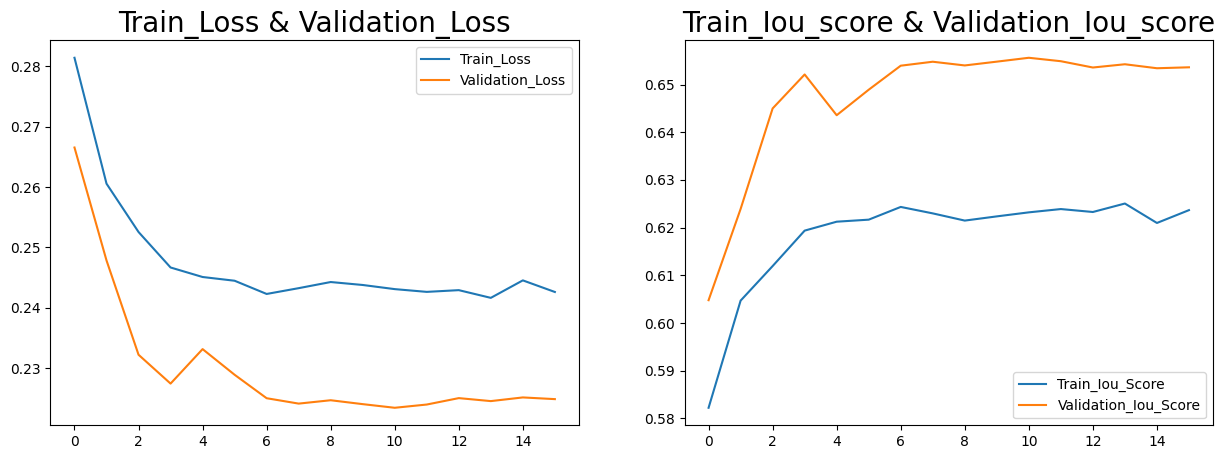

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

This is the Unet building part. This code is a classic when it comes for 2D  RGB binary problems and usually no change is needed to it

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(test_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=4)

This code implements DiceLoss function, which is the most used for medical image segmentation problems

In [ ]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.to(device)

def get_metrics(model, dataloder, threshold):
    IoU_score, precision, f1_score, recall, acc= 0, 0, 0, 0, 0
    batchs = 0
    model.eval()
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloder):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
            pred = model(x)
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)
            batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
            IoU_score += batch_iou_score
            acc += batch_acc
            f1_score += batch_f1_score
            recall += batch_recall
            precision += batch_precision
            batchs += 1
    IoU_score = round(IoU_score/batchs, 3)
    precision = round(precision/batchs, 3)
    f1_score = round(f1_score/batchs, 3)
    recall = round(recall/batchs, 3)
    acc = round(acc/batchs, 3)
    sample = {'iou':IoU_score, 'pre':precision, 'fi':f1_score, 're':recall, 'acc':acc}
    return sample

threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model, test_loader, threshold)
    print(f"threshold: {str(threshold)} \
    IoU Score: {sample['iou']:.3f} \
    precision: {sample['pre']:.3f} \
    dice_score: {sample['fi']:.3f} \
    Recall: {sample['re']:.3f} \
    Acc: {sample['acc']:.3f}")


threshold: 0.3     IoU Score: 0.653     precision: 0.766     dice_score: 0.790     Recall: 0.820     Acc: 0.962
threshold: 0.4     IoU Score: 0.655     precision: 0.780     dice_score: 0.792     Recall: 0.808     Acc: 0.963
threshold: 0.5     IoU Score: 0.656     precision: 0.792     dice_score: 0.792     Recall: 0.796     Acc: 0.964
threshold: 0.6     IoU Score: 0.656     precision: 0.805     dice_score: 0.792     Recall: 0.783     Acc: 0.964
threshold: 0.7     IoU Score: 0.655     precision: 0.818     dice_score: 0.791     Recall: 0.769     Acc: 0.965


Purpose: DiceBCELoss combines Dice Loss and Binary Cross-Entropy Loss into a single loss function to leverage the strengths of both.

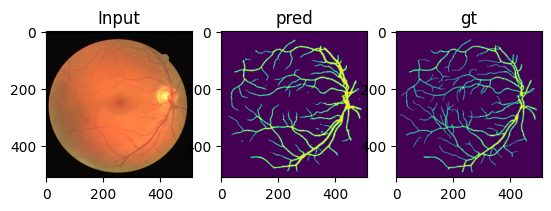

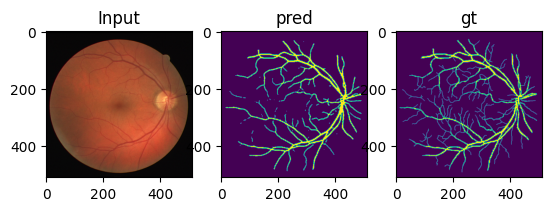

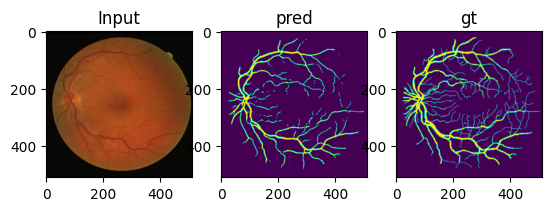

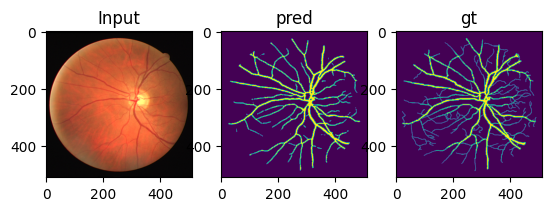

In [ ]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = np.where(pred<0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')

    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('gt')
    plt.show()


This function is used to ensure reproducibility across various libraries and frameworks by setting the same seed for random number generators.